The goal of this example is to train a dataset on top of a pre-trained model. 

## What are pre-trained models?

A pre-trained model is a model that has been trained on a large dataset to solve a problem similar to the one that we want to solve. The pre-trained model is then used to extract features from the dataset that we want to train. These features are then used to train a new model on the dataset. This is called transfer learning. Transfer learning is useful when we have a small dataset and we want to train a model on it. In this example, we will use a pre-trained model to extract features from the CIFAR-10 dataset and then train a new model on these features.

## Examples of pre-trained models

- ResNet: Robust network architecture that has been trained on the ImageNet dataset.
- Xception: Deep convolutional neural network that has been trained on the ImageNet dataset.
- ConvNeXt: Convolutional neural network that has been trained on the ImageNet dataset.
- YOLO: Object detection model that has been trained on the COCO dataset.


## Popular datasets

- ImageNet: Large dataset of images that has been used to train many pre-trained models. (I believe it's not publicly available)
- CIFAR-10: Small dataset of images that has been used to train many pre-trained models. (60,000 32x32 color images in 10 classes, with 6,000 images per class)
- COCO: Large dataset of images that has been used to train many pre-trained models. (330K images with 1.5 million object instances)
- MNIST: Small dataset of images that has been used to train many pre-trained models. (60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images)


### Question to answer
Try to train a model on top of a pre-trained model to classify a "dog" from the CIFAR-10 dataset. Compare it to YOLOv5.

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

In [2]:
CIFAR10_DS = tf.keras.datasets.cifar10.load_data()

In [3]:
# read cifar10 dataset

(x_train, y_train), (x_test, y_test) = CIFAR10_DS

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

[6]


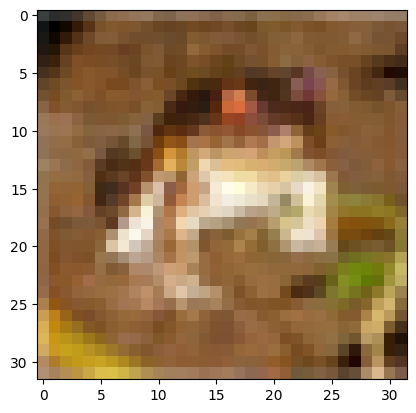

In [4]:
# read the first image to see if we need to normalise the data

import matplotlib.pyplot as plt
plt.imshow(x_train[0], cmap='gray')
print(y_train[0])
plt.show()


In [5]:
# get all labels
set(y_train.flatten())

{np.uint8(0),
 np.uint8(1),
 np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9)}

In [7]:
# we're going to do to a binary classification problem (either horse or not horse), therefore, we're going to change the labels to 1 if it's a horse and 0 if it's not a horse

y_train = (y_train == 7).astype(int)

set(y_train.flatten())

{np.int64(0), np.int64(1)}

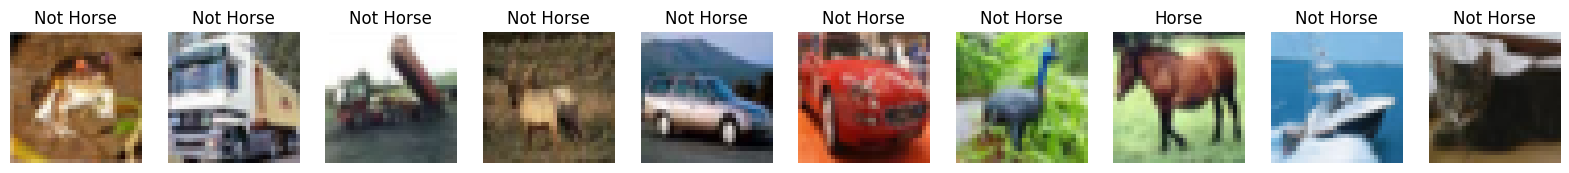

In [9]:
# check 10 images to see if they're horses

fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(x_train[i], cmap='gray')
    ax[i].set_title('Horse' if y_train[i] == 1 else 'Not Horse')
    ax[i].axis('off')

In [10]:
# Preproccessing before splitting the data

# normalise the data
x_train = x_train / 255

# split the data
from sklearn.model_selection import train_test_split

x_train_for_train, x_val, y_train_for_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train_for_train.shape, x_val.shape, y_train_for_train.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

In [11]:
# The model

# As we're going to train the model on top of the ResNet50, we're going to use it rather than building a model from scratch

from keras.applications import ResNet50

resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

resnet.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 38, 38, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 16, 16,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 16, 16,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 16, 16,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 18, 18,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 8, 8, 64)  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 8, 8, 64)  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_1_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 8, 8, 64)  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 8, 8, 64)  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 8, 8, 64)  │          0 │ conv2_block1_2_b… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 8, 8, 256) │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 8, 8, 256) │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 8, 8, 256) │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
# fit the model

model = Sequential([
    resnet, # ResNet50
    Flatten(), # flatten the output of ResNet50 to be able to pass it to the Dense layer
    Dropout(0.5), # to prevent overfitting
    Dense(1, activation='sigmoid') # binary classification
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 23,536,641 (89.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
history = model.fit(x_train_for_train, y_train_for_train, validation_data=(x_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 410s 314ms/step - accuracy: 0.9039 - loss: 0.3486 - val_accuracy: 0.9406 - val_loss: 0.2037
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 402s 322ms/step - accuracy: 0.9382 - loss: 0.1949 - val_accuracy: 0.9370 - val_loss: 0.1828
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 413s 330ms/step - accuracy: 0.9434 - loss: 0.1735 - val_accuracy: 0.9005 - val_loss: 14.9499
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 613s 491ms/step - accuracy: 0.8990 - loss: 0.4073 - val_accuracy: 0.9022 - val_loss: 0.2756
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 993s 795ms/step - accuracy: 0.9087 - loss: 0.2706 - val_accuracy: 0.9006 - val_loss: 1.0337
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 978s 783ms/step - accuracy: 0.9137 - loss: 0.2997 - val_accuracy: 0.9060 - val_loss: 0.2864
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 783s 627ms/step - accuracy: 0.9145 - loss: 0.2813 - val_accuracy: 0.9250 - val_loss: 0.2373
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 415s 332ms/step - a

In [21]:
# normilise x_test

x_test = x_test / 255
y_test = (y_test == 7).astype(int)

# evaluate the model
res, acc = model.evaluate(x_test, y_test)

print(f'Test accuracy: {acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 1.0000 - loss: 0.0395
Test accuracy: 1.0


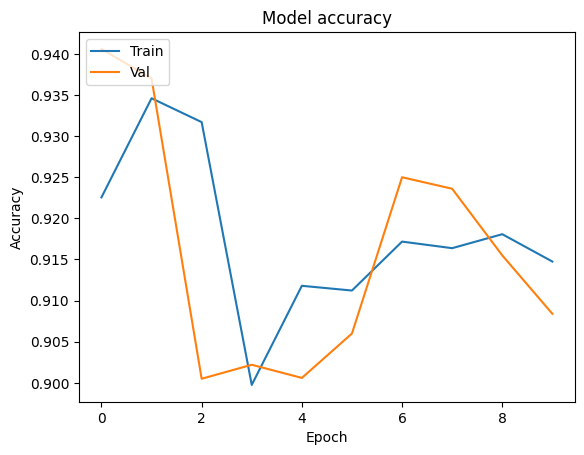

In [22]:
# plot the accuracy and loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


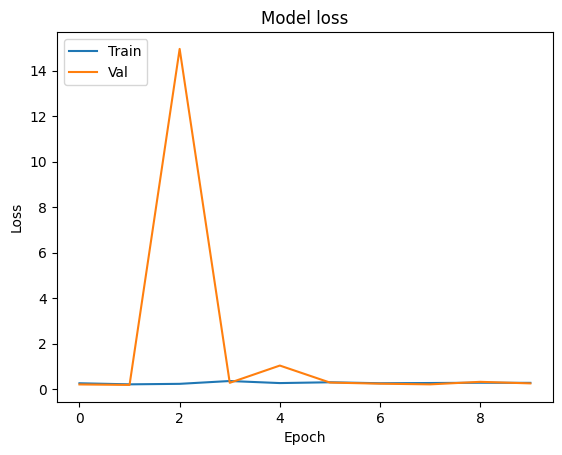

In [23]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()

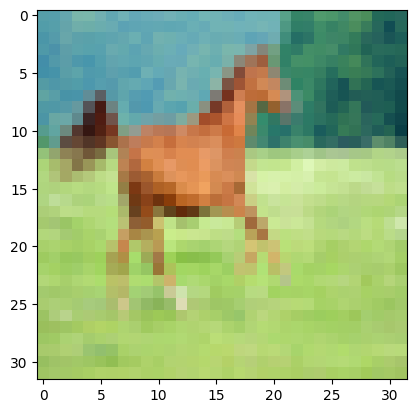

In [32]:
# random horse for testing

# from requests import get
# horse = get("https://images.squarespace-cdn.com/content/v1/54ab2b97e4b08dbf5e1cb50c/827087ca-536f-472e-a0dc-7662e8d30bd3/how+much+does+a+horse+weigh+%281%29.png?format=500w")

# with open('horse.png', 'wb') as f:
#     f.write(horse.content)

from PIL import Image
import numpy as np

img = Image.open('horse.png').convert('RGB')  # Ensure the image has 3 channels
img = img.resize((32, 32))
img = np.array(img)
img = img.reshape(32, 32, 3)
img = img / 255

plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


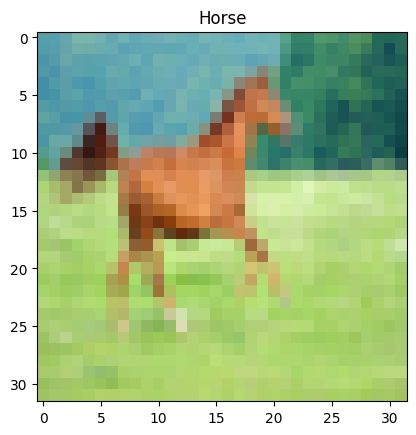

In [34]:
# predict

horse = model.predict(np.array([img]))

plt.imshow(img)
plt.title('Horse' if horse[0][0] > 0.5 else 'Not Horse')
plt.show()

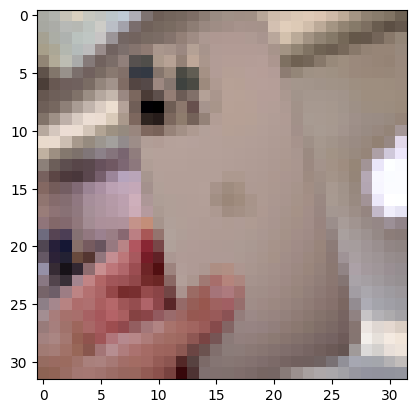

In [35]:
# not horse

from requests import get
not_horse = get("https://www.zdnet.com/a/img/resize/0258ce846d7b24064837b16a38756b526188dad1/2024/09/22/5404cdba-d88c-4f1b-982c-76197d0edf08/iphone-16-pro-apple-store-mall.jpg?auto=webp&fit=crop&height=1200&width=1200")

with open('not_horse.jpg', 'wb') as f:
    f.write(not_horse.content)

img = Image.open('not_horse.jpg').convert('RGB') 
img = img.resize((32, 32))
img = np.array(img)
img = img.reshape(32, 32, 3)
img = img / 255

plt.imshow(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


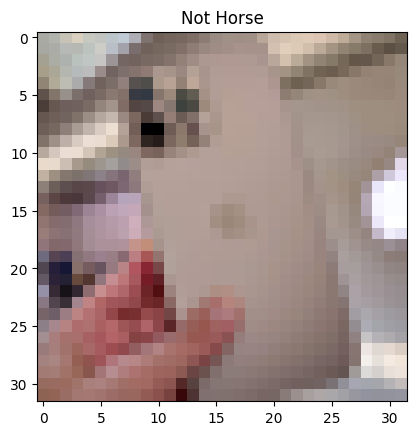

In [36]:
not_horse = model.predict(np.array([img]))

plt.imshow(img)
plt.title('Horse' if not_horse[0][0] > 0.5 else 'Not Horse')
plt.show()